In [2]:
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize, LogNorm
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import scqubits
from tqdm import tqdm
from IPython.display import clear_output
import qutip
from functools import partial
import matplotlib
from CoupledQuantumSystems.drive import *
from scipy.optimize import minimize

from CoupledQuantumSystems.noise import first_order_derivative,second_order_derivative,get_frequency,diel_spectral_density,one_over_f_spectral_density,T_phi
from CoupledQuantumSystems.IFQ import gfIFQ
from CoupledQuantumSystems.evo import ODEsolve_and_post_process

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

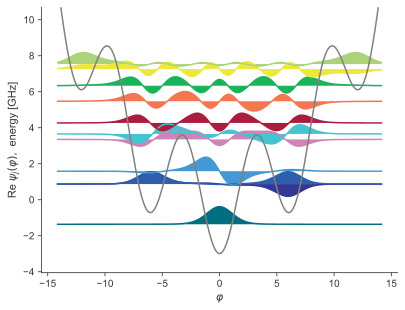

In [3]:
EJ = 3
EJoverEC = 6
EJoverEL = 25
EC = EJ / EJoverEC
EL = EJ / EJoverEL

qbt = gfIFQ(EJ = EJ,EC = EC, EL = EL, flux = 0,truncated_dim=20)
e_ops = [qutip.basis(qbt.truncated_dim, i)*qutip.basis(qbt.truncated_dim, i).dag() for i in range(10)]

element = np.abs(qbt.fluxonium.matrixelement_table('n_operator',evals_count=3)[1,2]) 
freq = (qbt.fluxonium.eigenvals()[2]-qbt.fluxonium.eigenvals()[1]) * 2 * np.pi
qbt.fluxonium.plot_wavefunction(which=[0,1,2,3,4,5,6,7,8,9,10])


In [6]:
def objective(x):
    t_tot = x[0]
    amp = x[1]
    tlist = np.linspace(0, t_tot*2, 100)

    initial_states = [qutip.basis(qbt.truncated_dim, 1),qutip.basis(qbt.truncated_dim, 2)]

    drive_terms = [
            DriveTerm(
                driven_op=qutip.Qobj(
                    qbt.fluxonium.n_operator(energy_esys=True)),
                pulse_shape_func=square_pulse_with_rise_fall,
                pulse_id='pi',
                pulse_shape_args={
                    'w_d': qbt.fluxonium.eigenvals()[2]-qbt.fluxonium.eigenvals()[1],  # Without 2pi
                    'amp': amp,  # Without 2pi
                    't_square': t_tot*0,
                    't_rise': t_tot
                },
            )
        ]
    qbt.get_pi_pulse_drive_terms(
        i = 1,
        j = 2,
        t_square=t_tot,
        amp = amp,
    )
    results = [ODEsolve_and_post_process(
                y0=initial_states[i],
                tlist=tlist,
                static_hamiltonian=qbt.diag_hamiltonian,
                drive_terms=drive_terms,
                # c_ops=c_ops,
                e_ops=e_ops,
                ) for i in range(len(initial_states))]

    clear_output()
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()
    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1]))
    one_minus_pop1 = np.abs(1- (results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop1))
    return one_minus_pop2 + one_minus_pop1

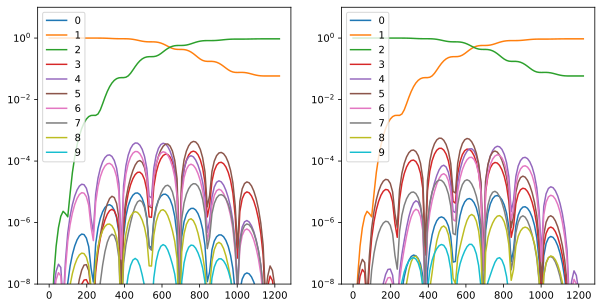

(0.05837359938673736, 0.058373545584642694)
 Total run time:   3.34s*] Elapsed 3.34s / Remaining 00:00:00:00
 [*********96%********** ] Elapsed 3.16s / Remaining 00:00:00:00

Traceback (most recent call last):
  File "qutip/cy/cqobjevo.pyx", line 212, in qutip.cy.cqobjevo.CQobjEvo.mul_vec
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
  File "qutip/cy/cqobjevo.pyx", line 679, in qutip.cy.cqobjevo.CQobjEvoTd._mul_vec
  File "qutip/cy/cqobjevo.pyx", line 293, in qutip.cy.cqobjevo.CQobjEvo._factor_dyn
  File "qutip/cy/cqobjevo.pyx", line 278, in qutip.cy.cqobjevo.CQobjEvo._factor
  File "/Users/jiakaiwang/miniconda3/envs/qec_sim/lib/python3.10/site-packages/qutip/qobjevo.py", line 1829, in __call__
    out.append(func(t, now_args))
  File "/Users/jiakaiwang/miniconda3/envs/qec_sim/lib/python3.10/site-packages/CoupledQuantumSystems/drive.py", line 44, in wrapper
    return self.pulse_shape_func(t, unmodified_args)
  File "/Users/jiakaiwang/miniconda3/envs/qec_sim/lib/python3.10/site-packages/CoupledQu

: 

In [7]:
t_tot = 250
amp = np.pi/element/t_tot/3.1415/2
initial_guess =[t_tot,amp]
result = minimize(objective, initial_guess, method='Nelder-Mead')

 Total run time:   1.04s*] Elapsed 1.04s / Remaining 00:00:00:00[******** 36%           ] Elapsed 0.46s / Remaining 00:00:00:00
 Total run time:   0.96s*] Elapsed 0.96s / Remaining 00:00:00:00


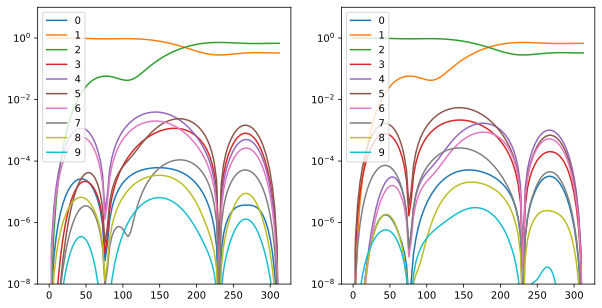

In [ ]:
objective([t_tot,amp])

 Total run time:   1.87s*] Elapsed 1.87s / Remaining 00:00:00:00
 Total run time:   1.76s*] Elapsed 1.76s / Remaining 00:00:00:00


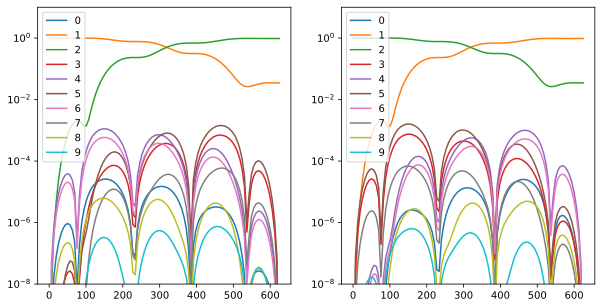

In [27]:
t_tot = 500
amp = np.pi/element/t_tot/3.1415/2
objective([t_tot,amp])

 Total run time:   6.84s*] Elapsed 6.84s / Remaining 00:00:00:00
 Total run time:   6.69s*] Elapsed 6.69s / Remaining 00:00:00:00


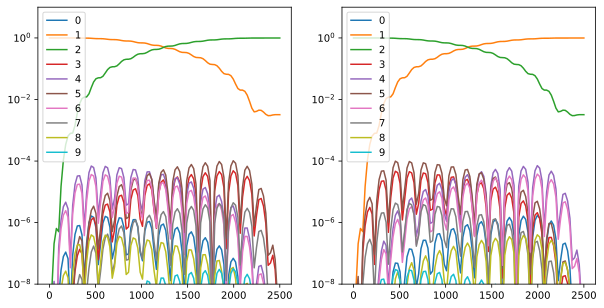

In [25]:
t_tot = 2000
amp = np.pi/element/t_tot/3.1415/2
objective([t_tot,amp])